### **PROYECTO NLP ALEJANDRO RIOS**

Lo primero que realizo, son todos los import necesarios para poder hacer el proyecto.

In [20]:
from sklearn.experimental import enable_halving_search_cv
import pandas as pd
import numpy as np
import gzip
import json
import joblib
import gc
import spacy
from sklearn.decomposition import PCA
from collections import Counter
from itertools import islice
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import torch
import cupy as cp
from joblib import Parallel, delayed
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# CARGA DEL DATASET Y ANÁLISIS EXPLORATORIO
file_path = "Video_Games_5.json.gz"
with gzip.open(file_path, "rt", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

corpus_df = pd.DataFrame(data)

En el código anterior he realizado la carga de los datos 📂, lo que me permite iniciar el análisis exploratorio del dataset 🔍.

In [3]:
print("🔹 Primeras filas del dataset:")
corpus_df.head()

🔹 Primeras filas del dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


En esta etapa, he visualizado las primeras filas del dataset 📊 utilizando corpus_df.head(). Esto me permite obtener una visión general de la estructura de los datos y verificar las columnas disponibles. Podemos comprobar que el dataset tiene información de reseñas sobre videojuegos, podemos observar columnas como reviewText (texto de la reseña), overall (puntuación), reviewTime (fecha de la reseña) y reviewerName (nombre del usuario). Existen valores nulos en algunas columnas, como vote, style e image, lo que indica que estas variables pueden requerir un tratamiento especial o ser descartadas en el análisis.

In [4]:
print("\n🔹 Columnas en el dataset:")
print(corpus_df.columns)


🔹 Columnas en el dataset:
Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')


Arriba, podemos ver que columnas contiene nuestro dataset.

In [5]:
print("\n🔹 Información del dataset:")
print(corpus_df.info())


🔹 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         497577 non-null  float64
 1   verified        497577 non-null  bool   
 2   reviewTime      497577 non-null  object 
 3   reviewerID      497577 non-null  object 
 4   asin            497577 non-null  object 
 5   reviewerName    497501 non-null  object 
 6   reviewText      497419 non-null  object 
 7   summary         497468 non-null  object 
 8   unixReviewTime  497577 non-null  int64  
 9   vote            107793 non-null  object 
 10  style           289237 non-null  object 
 11  image           3634 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 42.2+ MB
None


Usando corpus_df.info() he obtenido información detallada sobre el dataset, podemos comprobar que tenemos 497419 registros y 12 columnas.

In [6]:
print("\n🔹 Valores nulos en cada columna:")
print(corpus_df.isnull().sum())


🔹 Valores nulos en cada columna:
overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          76
reviewText           158
summary              109
unixReviewTime         0
vote              389784
style             208340
image             493943
dtype: int64


Utilizando corpus_df.isnull().sum() podemos saber cuandos valores nulos hay en el dataset y en cada columna, para poder realizar un mejor análisis de los datos.

In [7]:
corpus_df = corpus_df[corpus_df["reviewText"].notnull()]  # Filtrar nulos

Ahora paso a eliminar las filas donde reviewText es NaN para evitar problemas en el procesamiento.

In [8]:
# Estadísticas de la longitud de las reviews
corpus_df["review_length"] = corpus_df["reviewText"].apply(lambda x: len(x.split()))
print("\n🔹 Estadísticas de la longitud de las reviews:")
print(corpus_df["review_length"].describe())


🔹 Estadísticas de la longitud de las reviews:
count    497419.000000
mean        122.696216
std         226.993931
min           1.000000
25%          11.000000
50%          40.000000
75%         132.000000
max        5928.000000
Name: review_length, dtype: float64


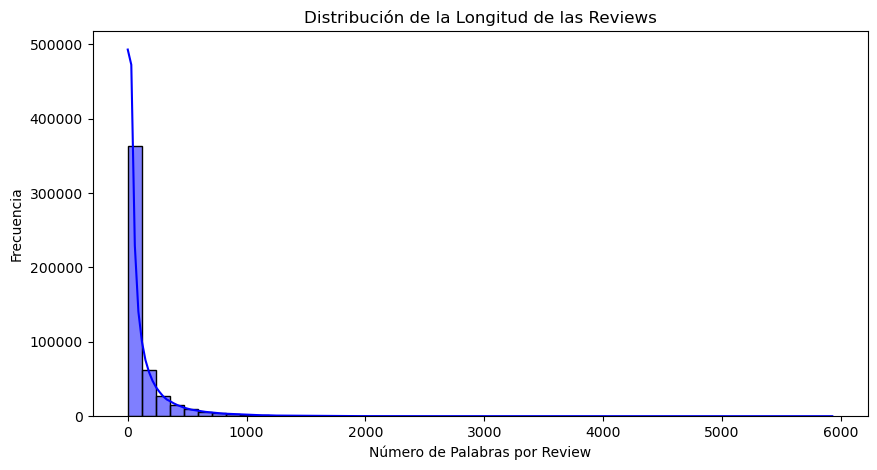

In [9]:
# Distribución de la longitud de las reviews
plt.figure(figsize=(10,5))
sns.histplot(corpus_df["review_length"], bins=50, kde=True, color="blue")
plt.xlabel("Número de Palabras por Review")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Longitud de las Reviews")
plt.show()

Ahora he generado un histograma 📊 que muestra la distribución de la longitud de las reviews en el dataset. Esta visualización me permite analizar cómo varía el número de palabras por reseña y detectar posibles valores atípicos.

Como observaciones clave podemos destacar:

- La mayoría de las reseñas son cortas, con menos de 50 palabras.
- Observamos una distribución asimétrica 📉, donde hay muy pocas reviews extremadamente largas (hasta más de 5000 palabras).
- La línea azul representa la densidad de la distribución (KDE), confirmando que la mayor parte de las reviews tienen una extensión baja.

C:\Users\alex-\AppData\Local\Temp\ipykernel_27572\280726061.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=corpus_df["overall"], palette="viridis")


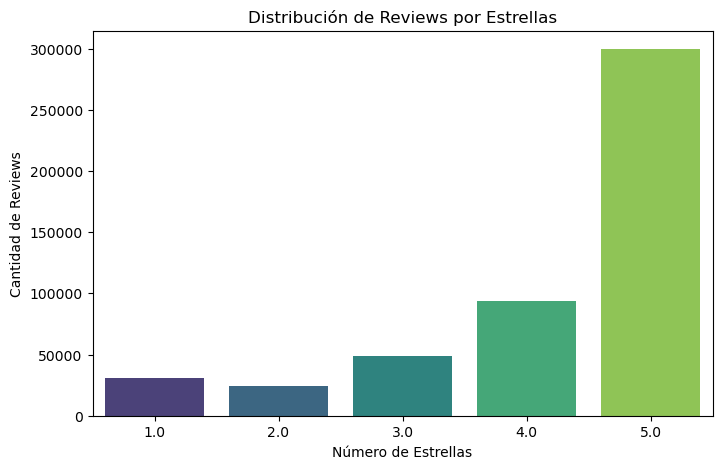

In [10]:
# Distribución de reviews por estrellas
plt.figure(figsize=(8,5))
sns.countplot(x=corpus_df["overall"], palette="viridis")
plt.xlabel("Número de Estrellas")
plt.ylabel("Cantidad de Reviews")
plt.title("Distribución de Reviews por Estrellas")
plt.show()

Generando un gráfico de barras 📊 que muestra la distribución de reviews según el número de estrellas, gracias a esto puedo entender como se distribuyen las opiniones en el dataset.

Observaciones clave:

- Existe un sesgo hacia las reseñas positivas, ya que la mayoría de los usuarios han dado 5 estrellas 🌟.
- Hay una menor cantidad de reseñas con 1 y 2 estrellas, lo que indica que hay pocos comentarios negativos en el dataset.
- Las reviews con 3 y 4 estrellas están menos representadas, lo que sugiere que los usuarios tienden a dejar opiniones muy positivas o muy negativas, pero rara vez neutrales.

In [11]:
# TOKENIZACIÓN OPTIMIZADA CON GPU
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

tokenized_texts = []
batch_size = 2000
for doc in nlp.pipe(corpus_df["reviewText"].astype(str).tolist(), batch_size=batch_size):
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    tokenized_texts.append(tokens)

corpus_df["tokens"] = tokenized_texts
corpus_df.to_csv("corpus_tokenized.csv", index=False)
print("✅ Tokenización completada y guardada en 'corpus_tokenized.csv'")

c:\Users\alex-\anaconda2\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


✅ Tokenización completada y guardada en 'corpus_tokenized.csv'


En el código de arriba he realizado la tokenización de los textos utilizando spaCy con aceleración en GPU. Esta optimización permite procesar cientos de miles de reseñas de manera eficiente, reduciendo considerablemente los tiempos de ejecución en comparación con una ejecución en CPU. 🚀🔍.

C:\Users\alex-\AppData\Local\Temp\ipykernel_27572\3588497301.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words], palette="Blues_r")


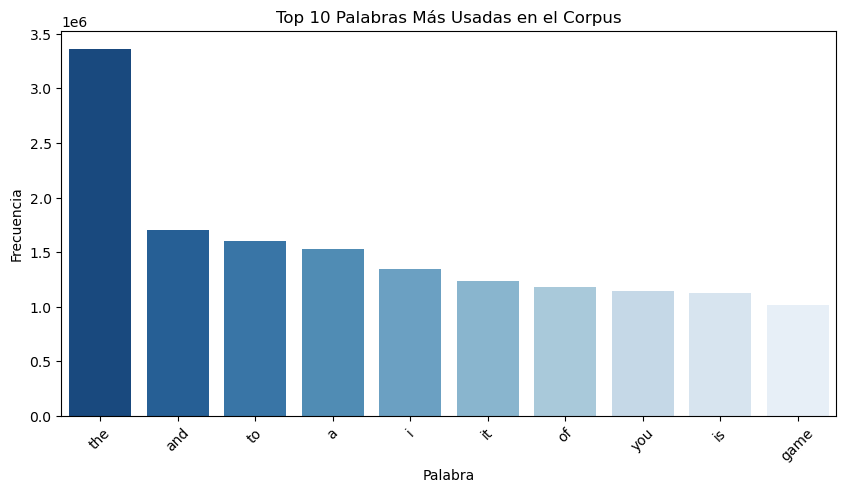

In [12]:
# Top 10 palabras más frecuentes
word_counts = Counter([word for tokens in tokenized_texts for word in tokens])
top_words = word_counts.most_common(10)
plt.figure(figsize=(10,5))
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words], palette="Blues_r")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.title("Top 10 Palabras Más Usadas en el Corpus")
plt.xticks(rotation=45)
plt.show()

Aquí he generado un gráfico de barras 📊 que muestra las 10 palabras más frecuentes en el corpus de reviews. Este análisis me ayuda a comprender qué términos predominan en el lenguaje utilizado por los usuarios.

Podemos observar lo siguiente:

- Las palabras más frecuentes son stopwords comunes en inglés como "the", "and", "to", "a", "i", "it", etc.
- Se observa que la palabra "game" aparece dentro del Top 10, lo cual es esperable ya que el dataset está relacionado con videojuegos. 🎮
- La presencia de estas stopwords puede afectar la calidad de los modelos de análisis de sentimiento, ya que no aportan información relevante sobre el contenido de las reseñas.

In [13]:
# ENTRENAR WORD2VEC
word2vec_model = Word2Vec(sentences=corpus_df["tokens"], vector_size=100, window=5, min_count=5, workers=4, sg=0)
word2vec_model.save("word2vec_reviews.model")

En este código entreno un modelo Word2Vec para aprender representaciones vectoriales de las palabras en nuestro corpus. Este modelo permite capturar relaciones semánticas entre palabras basándose en el contexto en el que aparecen en las reseñas.

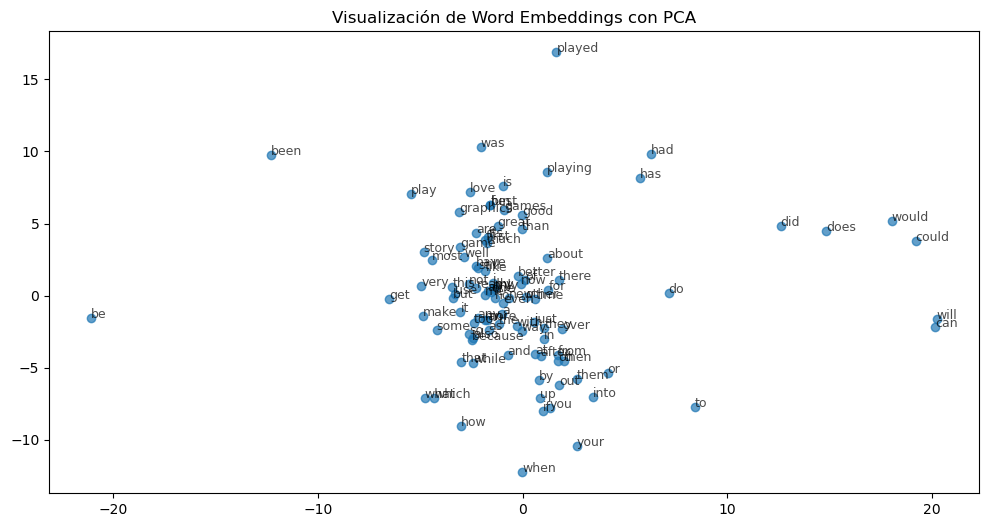

In [14]:
# Visualización de Word Embeddings en 2D
words = list(word2vec_model.wv.index_to_key)[:100]
word_vectors = np.array([word2vec_model.wv[word] for word in words])

pca = PCA(n_components=2)
word_vectors_2D = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 6))
plt.scatter(word_vectors_2D[:, 0], word_vectors_2D[:, 1], alpha=0.7)
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_2D[i, 0], word_vectors_2D[i, 1]), fontsize=9, alpha=0.7)
plt.title("Visualización de Word Embeddings con PCA")
plt.show()

Lo siguiente que he realizado es seleccionar las 100 palabras más frecuentes en el vocabulario del modelo Word2Vec, obtener sus representaciones vectoriales en 100 dimensiones, aplicar PCA para reducir la dimensionalidad a 2 dimensiones, para poder permitir que podamos visualizar las palabras en un gráfico. podemos ver como es la relación entre las palabras de forma visual en el gráfico.

In [ ]:
# Cargar Word2Vec y moverlo a PyTorch
word2vec_model = Word2Vec.load("word2vec_reviews.model")
word_vectors = torch.tensor(word2vec_model.wv.vectors, device="cuda").detach().cpu().numpy()  # Convertir a NumPy
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(corpus_df["reviewText"].astype(str))
tfidf_vocab = set(vectorizer.get_feature_names_out())
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Procesar TF-IDF en GPU en lotes
batch_size = 5000
X_hybrid = []

for start in range(0, len(corpus_df), batch_size):
    end = min(start + batch_size, len(corpus_df))
    print(f"🚀 Procesando batch {start} - {end}...")

    # Mover solo el batch a GPU
    tfidf_batch = cp.array(tfidf_matrix[start:end].toarray())  

    X_hybrid_batch = []
    
    for idx, text in enumerate(corpus_df["reviewText"][start:end]):
        words = text.split()
        valid_words = [word for word in words if word in word_index and word in tfidf_vocab]
        word_ids = [word_index[word] for word in valid_words]
        tfidf_values = [tfidf_batch[idx, vectorizer.vocabulary_.get(word, 0)] for word in valid_words]

        if not word_ids or not tfidf_values:
            X_hybrid_batch.append(cp.zeros(word_vectors.shape[1]))  
        else:
            word_vectors_gpu = cp.array(word_vectors[word_ids])  
            tfidf_values_gpu = cp.array(tfidf_values).reshape(-1, 1)  
            weighted_vectors = tfidf_values_gpu * word_vectors_gpu  
            X_hybrid_batch.append(cp.mean(weighted_vectors, axis=0))  
    
    X_hybrid.append(cp.asnumpy(cp.vstack(X_hybrid_batch)))  
    del tfidf_batch, X_hybrid_batch  
    torch.cuda.empty_cache()  
    gc.collect()  

X_hybrid = np.vstack(X_hybrid)

# 🔹 Convertir etiquetas
y = corpus_df["overall"].apply(lambda x: 1 if x >= 4 else 0)

print("✅ Vectorización TF-IDF + Word2Vec optimizada en GPU completada 🚀")

🚀 Procesando batch 0 - 5000...
🚀 Procesando batch 5000 - 10000...
🚀 Procesando batch 10000 - 15000...
🚀 Procesando batch 15000 - 20000...
🚀 Procesando batch 20000 - 25000...
🚀 Procesando batch 25000 - 30000...
🚀 Procesando batch 30000 - 35000...
🚀 Procesando batch 35000 - 40000...
🚀 Procesando batch 40000 - 45000...
🚀 Procesando batch 45000 - 50000...
🚀 Procesando batch 50000 - 55000...
🚀 Procesando batch 55000 - 60000...
🚀 Procesando batch 60000 - 65000...
🚀 Procesando batch 65000 - 70000...
🚀 Procesando batch 70000 - 75000...
🚀 Procesando batch 75000 - 80000...
🚀 Procesando batch 80000 - 85000...
🚀 Procesando batch 85000 - 90000...
🚀 Procesando batch 90000 - 95000...
🚀 Procesando batch 95000 - 100000...
🚀 Procesando batch 100000 - 105000...
🚀 Procesando batch 105000 - 110000...
🚀 Procesando batch 110000 - 115000...
🚀 Procesando batch 115000 - 120000...
🚀 Procesando batch 120000 - 125000...
🚀 Procesando batch 125000 - 130000...
🚀 Procesando batch 130000 - 135000...
🚀 Procesando batch 

In [18]:
# Dividir Datos en Train y Test (ANTES de aplicar SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y, test_size=0.2, random_state=42, stratify=y)

# Balanceo de Clases con SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler
joblib.dump(scaler, "scaler.pkl")

# Definir hiperparámetros óptimos
param_dist_logreg = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
param_dist_rf = {'n_estimators': [100, 300], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}


print("Regresión Logística")
random_logreg = RandomizedSearchCV(LogisticRegression(max_iter=1000), 
                                   param_distributions=param_dist_logreg, 
                                   n_iter=5, cv=3, n_jobs=-1, random_state=42)
random_logreg.fit(X_train_scaled, y_train_bal)
best_logreg = random_logreg.best_estimator_

print("Random Forest")
halving_rf = HalvingRandomSearchCV(RandomForestClassifier(), 
                                   param_distributions=param_dist_rf, 
                                   factor=2,
                                   cv=3, n_jobs=-1, random_state=42)
halving_rf.fit(X_train_scaled, y_train_bal)
best_rf = halving_rf.best_estimator_

# ENTRENAMIENTO OPTIMIZADO EN GPU
print("Entrenando XGBoost en GPU")
best_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                         tree_method='gpu_hist', 
                         n_estimators=100, learning_rate=0.1, max_depth=3)
best_xgb.fit(X_train_scaled, y_train_bal)

print("Entrenando LightGBM en GPU")
best_lgbm = LGBMClassifier(device='gpu', n_estimators=100, learning_rate=0.1, num_leaves=31)
best_lgbm.fit(X_train_scaled, y_train_bal)

# Guardar modelos
joblib.dump(best_logreg, "best_logreg.pkl")
joblib.dump(best_rf, "best_rf.pkl")
joblib.dump(best_xgb, "best_xgb.pkl")
joblib.dump(best_lgbm, "best_lgbm.pkl")

print("✅ ¡Entrenamiento completo!")

Regresión Logística
Random Forest


c:\Users\alex-\anaconda2\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=39326. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Entrenando XGBoost en GPU


c:\Users\alex-\anaconda2\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\alex-\anaconda2\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Entrenando LightGBM en GPU
[LightGBM] [Info] Number of positive: 314613, number of negative: 157306
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 471919, number of used features: 100
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2080 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (45.01 MB) transferred to GPU in 0.025358 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693150
[LightGBM] [Info] Start training from score 0.693150
✅ ¡Entrenamiento completo!


c:\Users\alex-\anaconda2\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [21]:
# Evaluación de los Modelos
models = {
    "Regresión Logística": best_logreg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "LightGBM": best_lgbm
}

metricas = {}

for name, model in models.items():
    print(f"\n🔹 Reporte de Clasificación - {name}")
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Guardar métricas en un diccionario
    metricas[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }


🔹 Reporte de Clasificación - Regresión Logística

🔹 Reporte de Clasificación - Random Forest

🔹 Reporte de Clasificación - XGBoost


c:\Users\alex-\anaconda2\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



🔹 Reporte de Clasificación - LightGBM


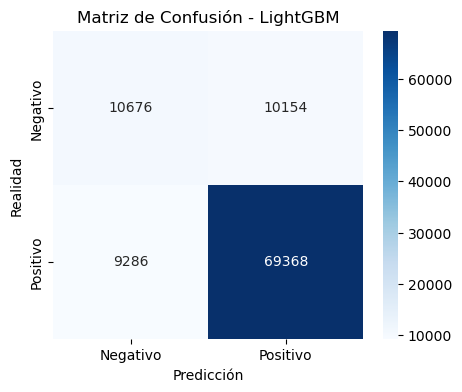

In [22]:
# Matriz de Confusión
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title(f"Matriz de Confusión - {name}")
plt.show()

Podemos comprobar lo siguiente:

- El modelo identifica correctamente 69,368 casos positivos, lo que indica una buena capacidad para reconocer esta clase-
- Por otro lado tenemos un número considerable de falsos negativos (9,286) y falsos pisitivos (10,154), esto nos sugiere que el modelo tiene margen de mejora en la distición entre clases.

In [23]:
# Comparación de Métricas
df_metricas = pd.DataFrame(metricas).T
print("\n🔹 Comparación de Métricas entre Modelos:")
display(df_metricas)


🔹 Comparación de Métricas entre Modelos:


,Accuracy,Precision,Recall,F1-score
Regresión Logística,0.791032,0.807279,0.966397,0.879701
Random Forest,0.830455,0.860219,0.937969,0.897413
XGBoost,0.792469,0.861259,0.879129,0.870102
LightGBM,0.804592,0.872312,0.881939,0.877099


Podemos observar lo siguiente:

- ✅ Mejor Accuracy: Random Forest (0.83)
- ✅ Mejor Precision: LightGBM (0.87)
- ✅ Mejor Recall: Regresión Logística (0.96)
- ✅ Mejor F1-score: Random Forest (0.89)

Random Forest nos ofrece el mejor balance general entre exactitud, precisión y F1-score, lo que lo convierte en una opción sólida.
LightGBM tiene la mejor precisión, lo que significa que minimiza falsos positivos, lo que puede ser clave si los falsos positivos son un problema crítico.
Regresión Logística tiene el mejor recall, lo que significa que es excelente en identificar positivos, pero con más falsos positivos.
XGBoost tiene un desempeño similar a LightGBM, pero ligeramente inferior en F1-score y accuracy.

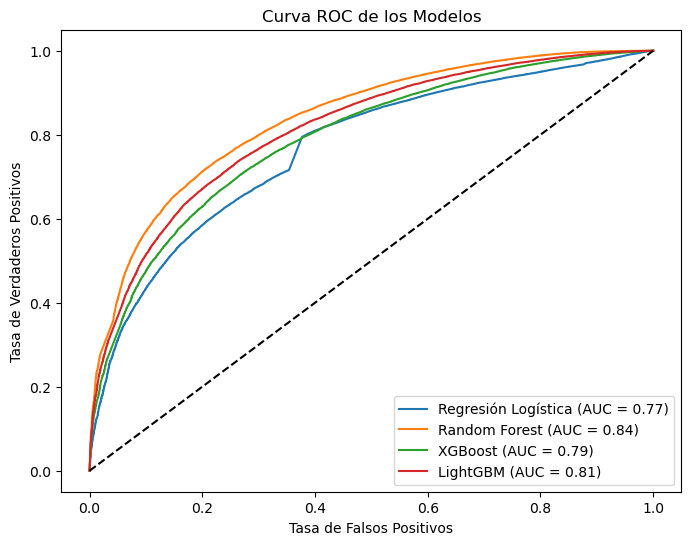

In [24]:
# Curva ROC y AUC
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')  # Línea base (azar)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC de los Modelos")
plt.legend()
plt.show()

La curva ROC (Receiver Operating Characteristic) evalúa la capacidad de los modelos para diferenciar entre clases positivas y negativas. La métrica AUC (Área Bajo la Curva) indica la calidad del modelo:

- AUC cercano a 1 → Modelo excelente.
- AUC = 0.5 → Modelo sin poder predictivo (aleatorio).

En este caso tenemos lo siguiente:

- Random Forest tiene el mejor AUC (0.84), lo que indica que es el modelo con mejor capacidad discriminatoria.
- LightGBM también obtiene un buen AUC (0.81), aunque ligeramente inferior a Random Forest.
- XGBoost y Regresión Logística tienen un rendimiento más bajo (0.79 y 0.77, respectivamente).

Random Forest es el mejor modelo en esta evaluación.

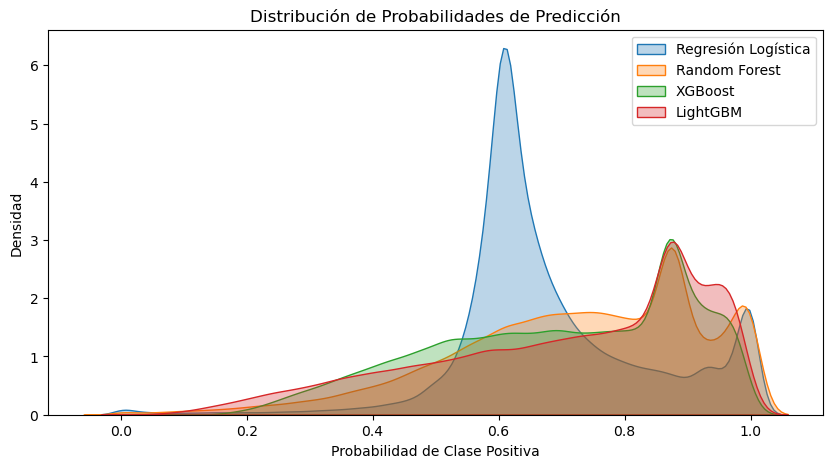

In [25]:
# Visualización de Distribución de Probabilidades de Predicción
plt.figure(figsize=(10,5))
for name, model in models.items():
    sns.kdeplot(model.predict_proba(X_test_scaled)[:, 1], label=name, fill=True, alpha=0.3)
plt.xlabel("Probabilidad de Clase Positiva")
plt.ylabel("Densidad")
plt.title("Distribución de Probabilidades de Predicción")
plt.legend()
plt.show()

Con esta gráfica podemos observar lo siguiente:

- Random Forest y LightGBM generan predicciones con mayor confianza, ya que tienen acumulación en valores cercanos a 1.
- Regresión Logística tiene más dispersión, lo que podría indicar menor confianza en sus predicciones.
- XGBoost y LightGBM presentan distribuciones equilibradas, lo que sugiere que podrían ser más robustos frente a incertidumbre en los datos.

### **EJEMPLO PREDICCION**

In [27]:
# Frases de prueba para predecir el sentimiento
nuevas_frases = [
    "I absolutely love this game! The graphics are stunning and the gameplay is fantastic!",
    "This product is terrible. It stopped working after one day. Don't waste your money!",
    "The game is okay, but it could be better. Some features are missing.",
    "Amazing experience! Highly recommended for all fans of the genre.",
    "Not the best purchase, but not the worst either. Just average."
]

# Vectorizar las frases nuevas usando el mismo pipeline
def vectorizar_texto(texto, vectorizer, word_index, word_vectors):
    words = texto.split()
    valid_words = [word for word in words if word in word_index]
    word_ids = [word_index[word] for word in valid_words]
    tfidf_values = [vectorizer.transform([word]).toarray()[0][vectorizer.vocabulary_.get(word, 0)] for word in valid_words]

    if not word_ids or not tfidf_values:
        return np.zeros(word_vectors.shape[1])
    
    word_vectors_np = np.array([word_vectors[i] for i in word_ids])
    weighted_vectors = np.array(tfidf_values).reshape(-1, 1) * word_vectors_np
    return np.mean(weighted_vectors, axis=0)

# Convertir nuevas frases en vectores
X_nuevas = np.array([vectorizar_texto(frase, vectorizer, word_index, word_vectors) for frase in nuevas_frases])
X_nuevas_scaled = scaler.transform(X_nuevas)  # Normalizar como en entrenamiento

# Hacer predicciones con el mejor modelo
predicciones = best_lgbm.predict(X_nuevas_scaled)

# Mostrar resultados
for frase, pred in zip(nuevas_frases, predicciones):
    sentimiento = "Positivo" if pred == 1 else "Negativo"
    print(f"📝 Frase: \"{frase}\" ➝  🔹 Predicción: {sentimiento}")

📝 Frase: "I absolutely love this game! The graphics are stunning and the gameplay is fantastic!" ➝  🔹 Predicción: Positivo
📝 Frase: "This product is terrible. It stopped working after one day. Don't waste your money!" ➝  🔹 Predicción: Negativo
📝 Frase: "The game is okay, but it could be better. Some features are missing." ➝  🔹 Predicción: Negativo
📝 Frase: "Amazing experience! Highly recommended for all fans of the genre." ➝  🔹 Predicción: Positivo
📝 Frase: "Not the best purchase, but not the worst either. Just average." ➝  🔹 Predicción: Negativo


Con el código de arriba podemos comprobar como funcionan nuestras predicciones.

### **FIN**